In [1]:
# change to parent directory to import module
%cd ..

/home/achilleas/projects/osbuild/metrics


In [2]:
# imports, function definitions, and global settings
import json
import pandas
import report

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ibmetrics as ib

from datetime import datetime, timedelta

from IPython.display import display, Markdown


def mdprint(msg):
    display(Markdown(msg))
    
matplotlib.rc('font', size=24)

In [3]:
# read data
year = 2023
month = 3
builds = ib.reader.read(f"./data/parquet/builds/year_created={year}/month_created={month}/day_created=1")
users = pandas.read_json("./data/userinfo.json", dtype=False)
with open("./data/userfilter.txt", encoding="utf-8") as filterfile:
    user_filter = filterfile.read().split("\n")
    
subscriptions = pandas.read_csv("./data/16_image-builder-consumers.tsv",
                                delimiter="\t", parse_dates=[2, 3],
                                dtype={"org_id": str})

filter_ids = ib.data.get_filter_ids(users, user_filter)

mdprint(f"Builds: Read {len(builds)} records")
mdprint(f"Subscriptions: Read {len(subscriptions)} records")

Builds: Read 13173 records

Subscriptions: Read 6124 records

In [4]:
# filtering: remove builds before GA
ga_date = datetime(2022, 5, 4)
ga_idxs = builds["created_at"] >= ga_date
builds = builds.loc[ga_idxs]

# filtering: remove builds of incomplete (current) month
now = datetime.now()
month_start = datetime(year=year, month=month, day=1)
builds = builds.loc[builds["created_at"] < month_start]
mdprint(f"Builds: Using {len(builds)} records (since GA to start of month)")
subscriptions = subscriptions.loc[subscriptions["created"] < month_start]
mdprint(f"Subscriptions: Using {len(subscriptions)} records (since GA to start of month)")

# filtering: remove internal users
builds = ib.data.filter_orgs(builds, filter_ids)
mdprint(f"Builds: Using {len(builds)} records (after filtering)")
subscriptions = ib.data.filter_orgs(subscriptions, filter_ids)
mdprint(f"Subscriptions: Using {len(subscriptions)} records (after filtering)")

Builds: Using 11338 records (since GA to start of month)

Subscriptions: Using 5962 records (since GA to start of month)

Builds: Using 5238 records (after filtering)

Subscriptions: Using 2084 records (after filtering)

In [5]:
summary = ib.metrics.make_summary(builds)
mdprint(ib.metrics.summarise(summary))

Summary
=======

Period: 2022-05-04 14:11:47.137615 - 2023-02-28 23:57:43.325515

- Total builds: 5238
- Number of users: 2185
- Builds with packages: 2503
- Builds with filesystem customizations: 1404
- Builds with custom repos: 83

In [6]:
# Calculate total subscribed machine duration
durations = []

n_active = 0
# machine is active if it checked in after the cutoff: last day of the month we're looking at
cutoff = month_start - timedelta(days=1)
for _, sub in subscriptions.iterrows():
    start = np.datetime64(sub["created"])
    
    if sub["lastcheckin"] == "None":
        # skip machines that never checked in after creation
        continue
    end = np.datetime64(sub["lastcheckin"])

    d = (end-start).astype(int)/1000000 # microseconds to seconds
    
    if end > cutoff:
        n_active += 1
    durations.append(d)

total_duration = sum(durations)
print(f"{total_duration} seconds total active instances")
print(f"{np.mean(durations)} seconds average lifetime per instance")
print(f"{n_active} active instances (checked in within one day before {month_start})")
print(f"{len(durations)} instances that checked in at least once")

2101086532.0 seconds total active instances
1605108.1222307105 seconds average lifetime per instance
310 active instances (checked in within one day before 2023-03-01 00:00:00)
1309 instances that checked in at least once


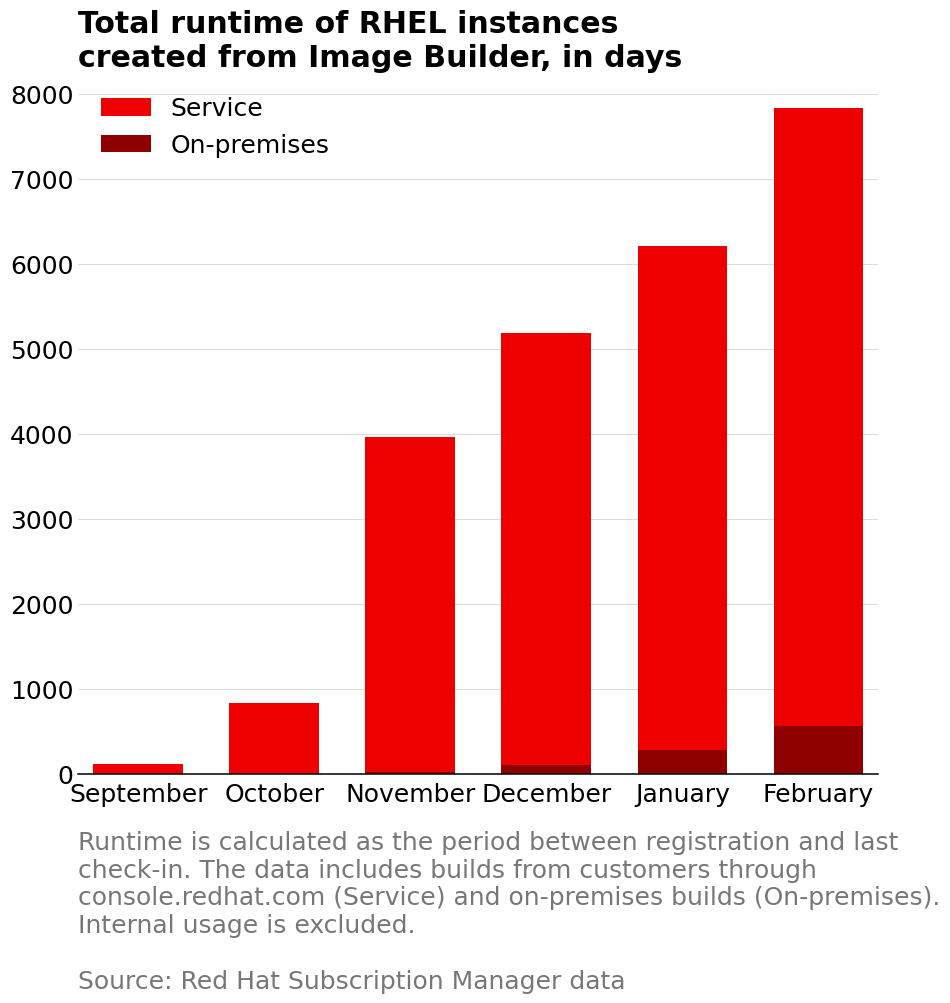

In [7]:
fig = plt.figure(figsize=(8, 7))
ib.plot.monthly_active_time(subscriptions, fig)

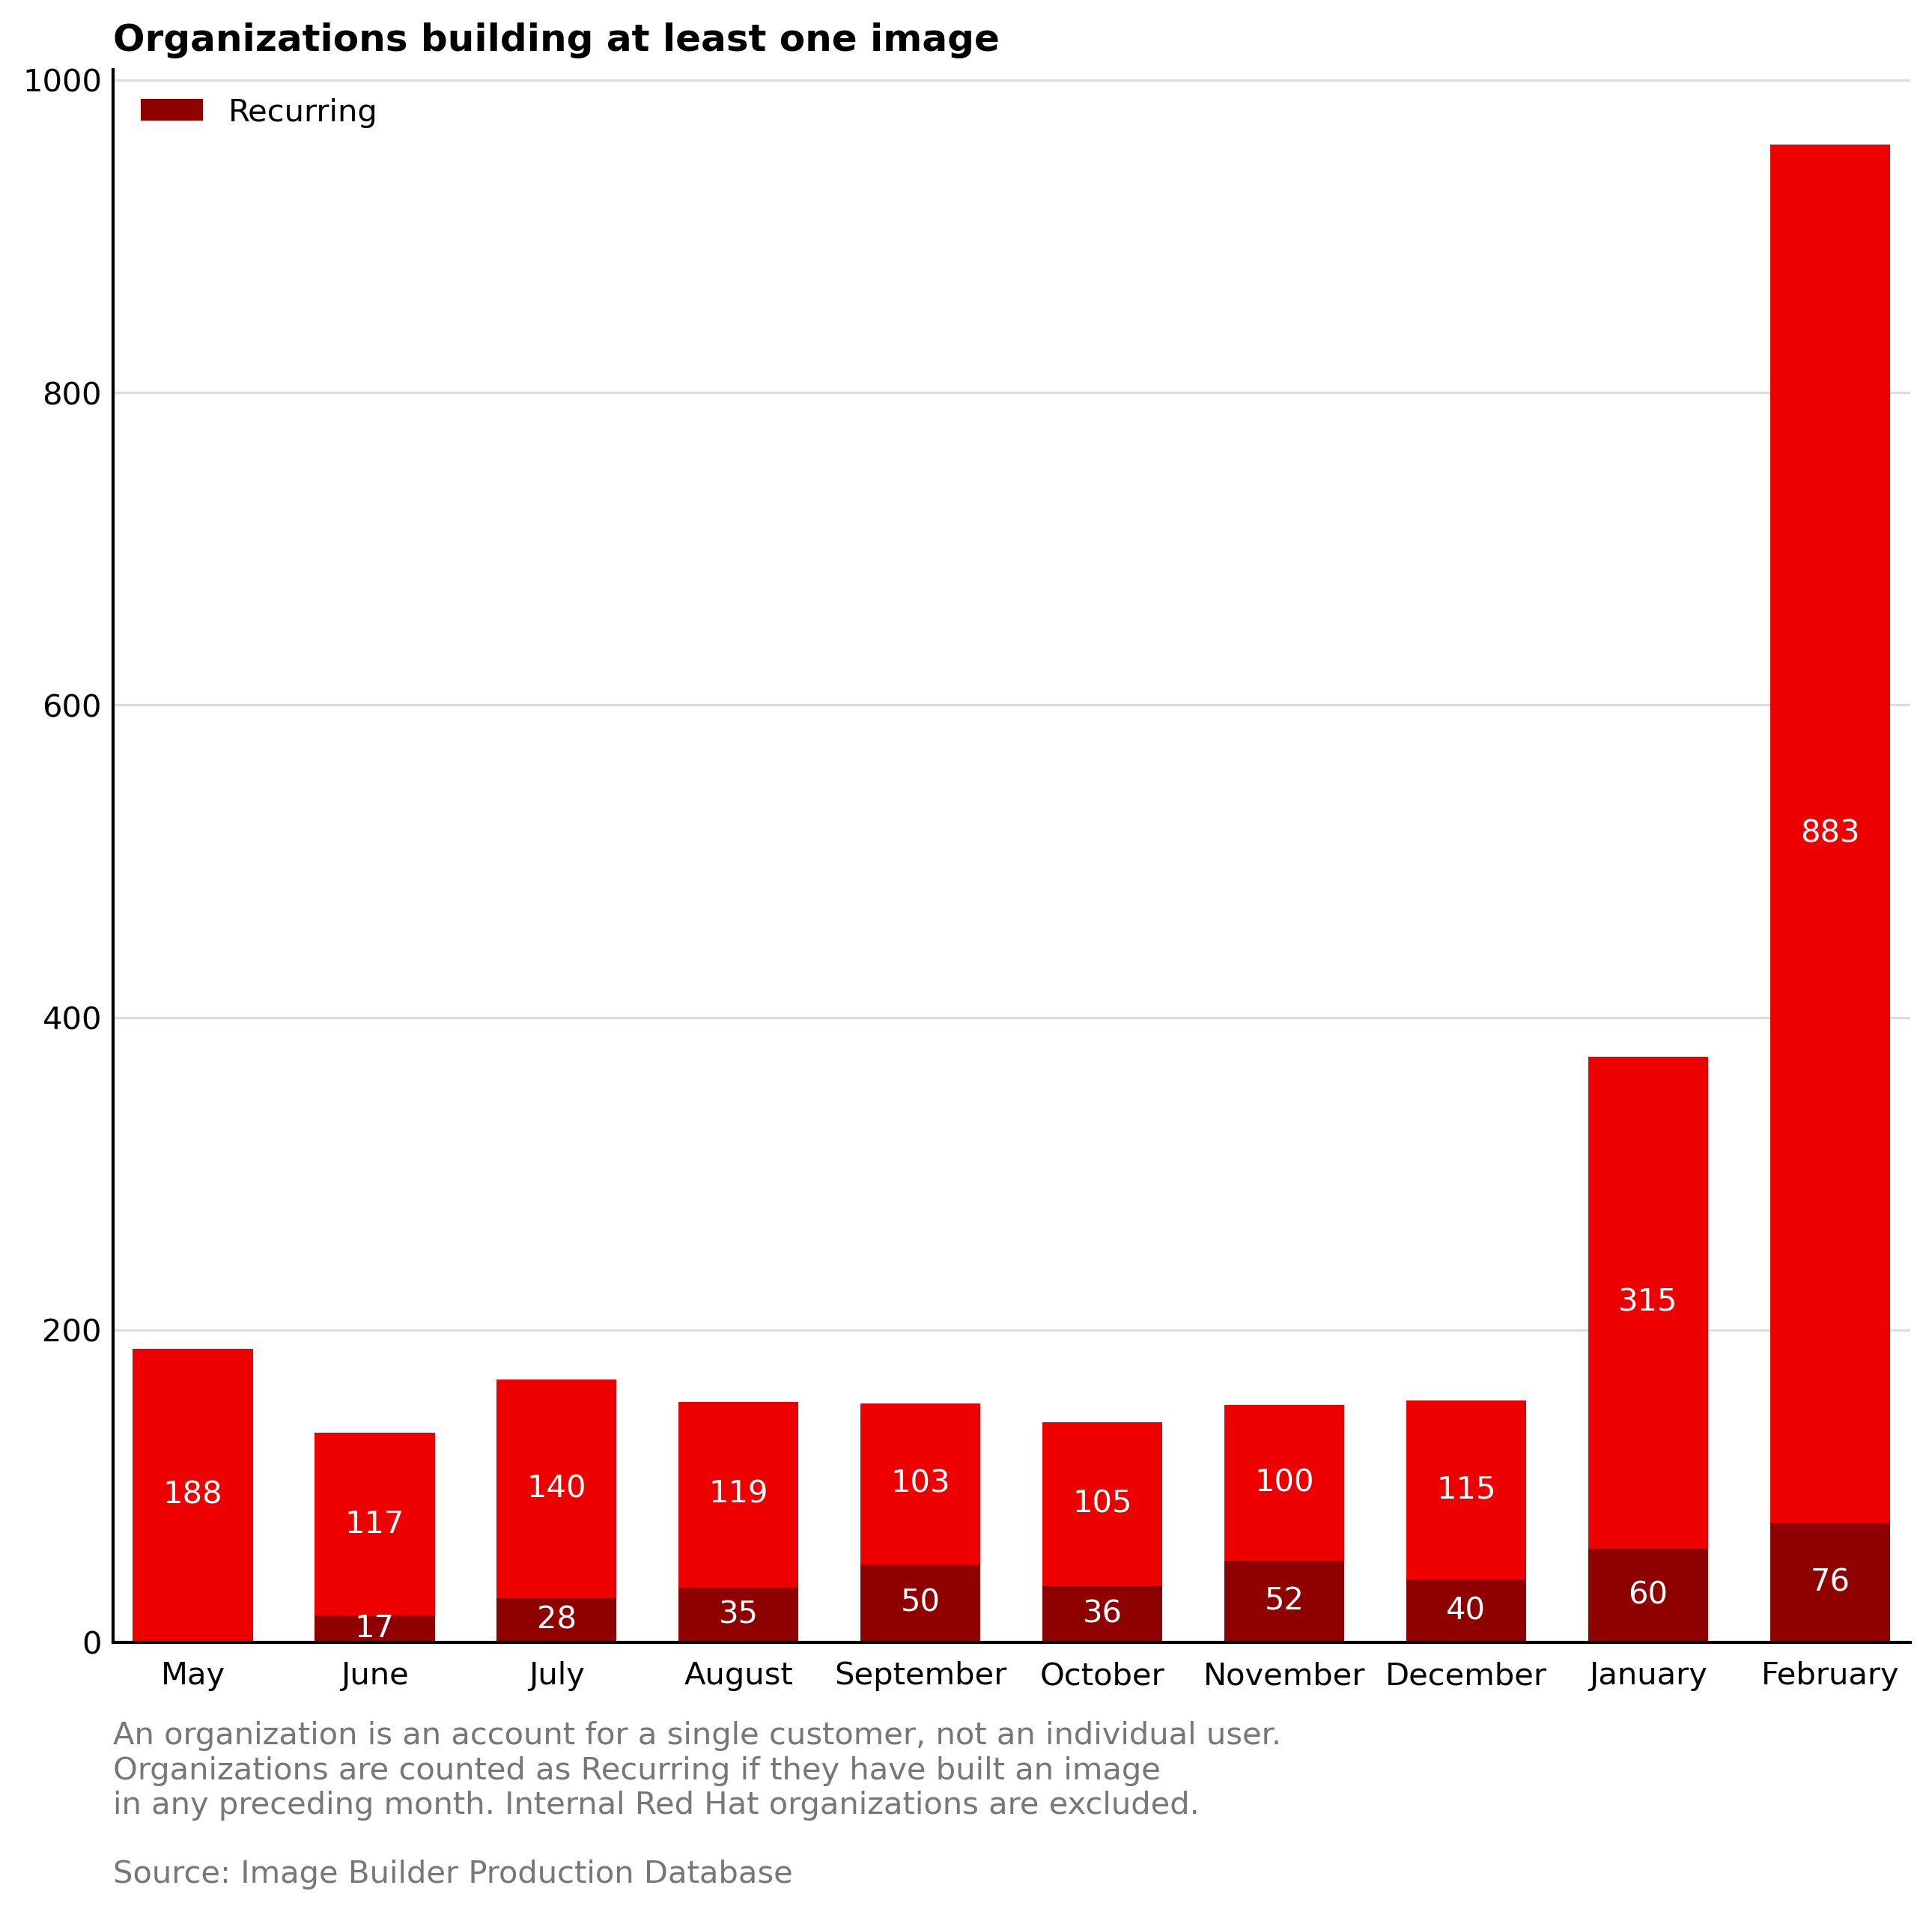

In [8]:
fig = plt.figure(figsize=(8, 7))
ib.plot.monthly_users_stacked(builds, fig)

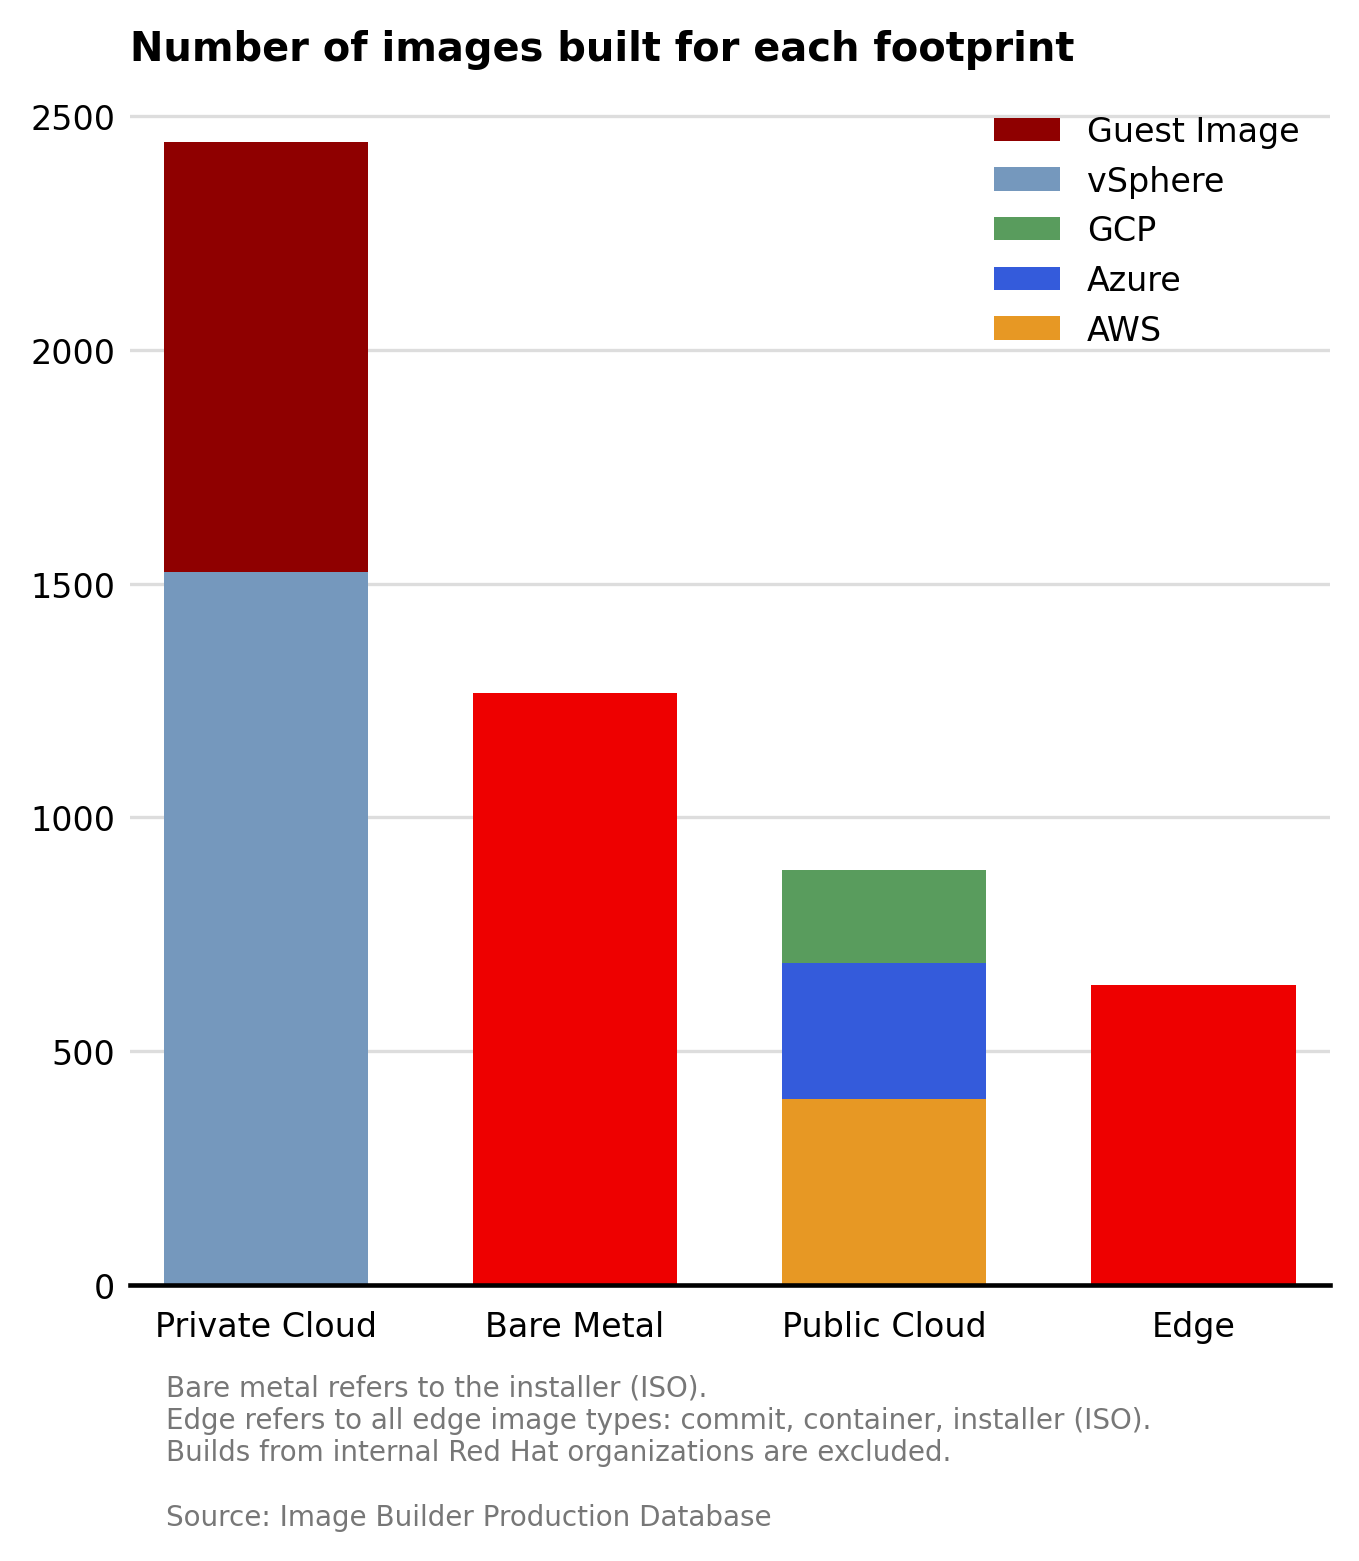

In [9]:
fig = plt.figure(figsize=(4, 4))
ib.plot.footprints_stacked(builds, fig)

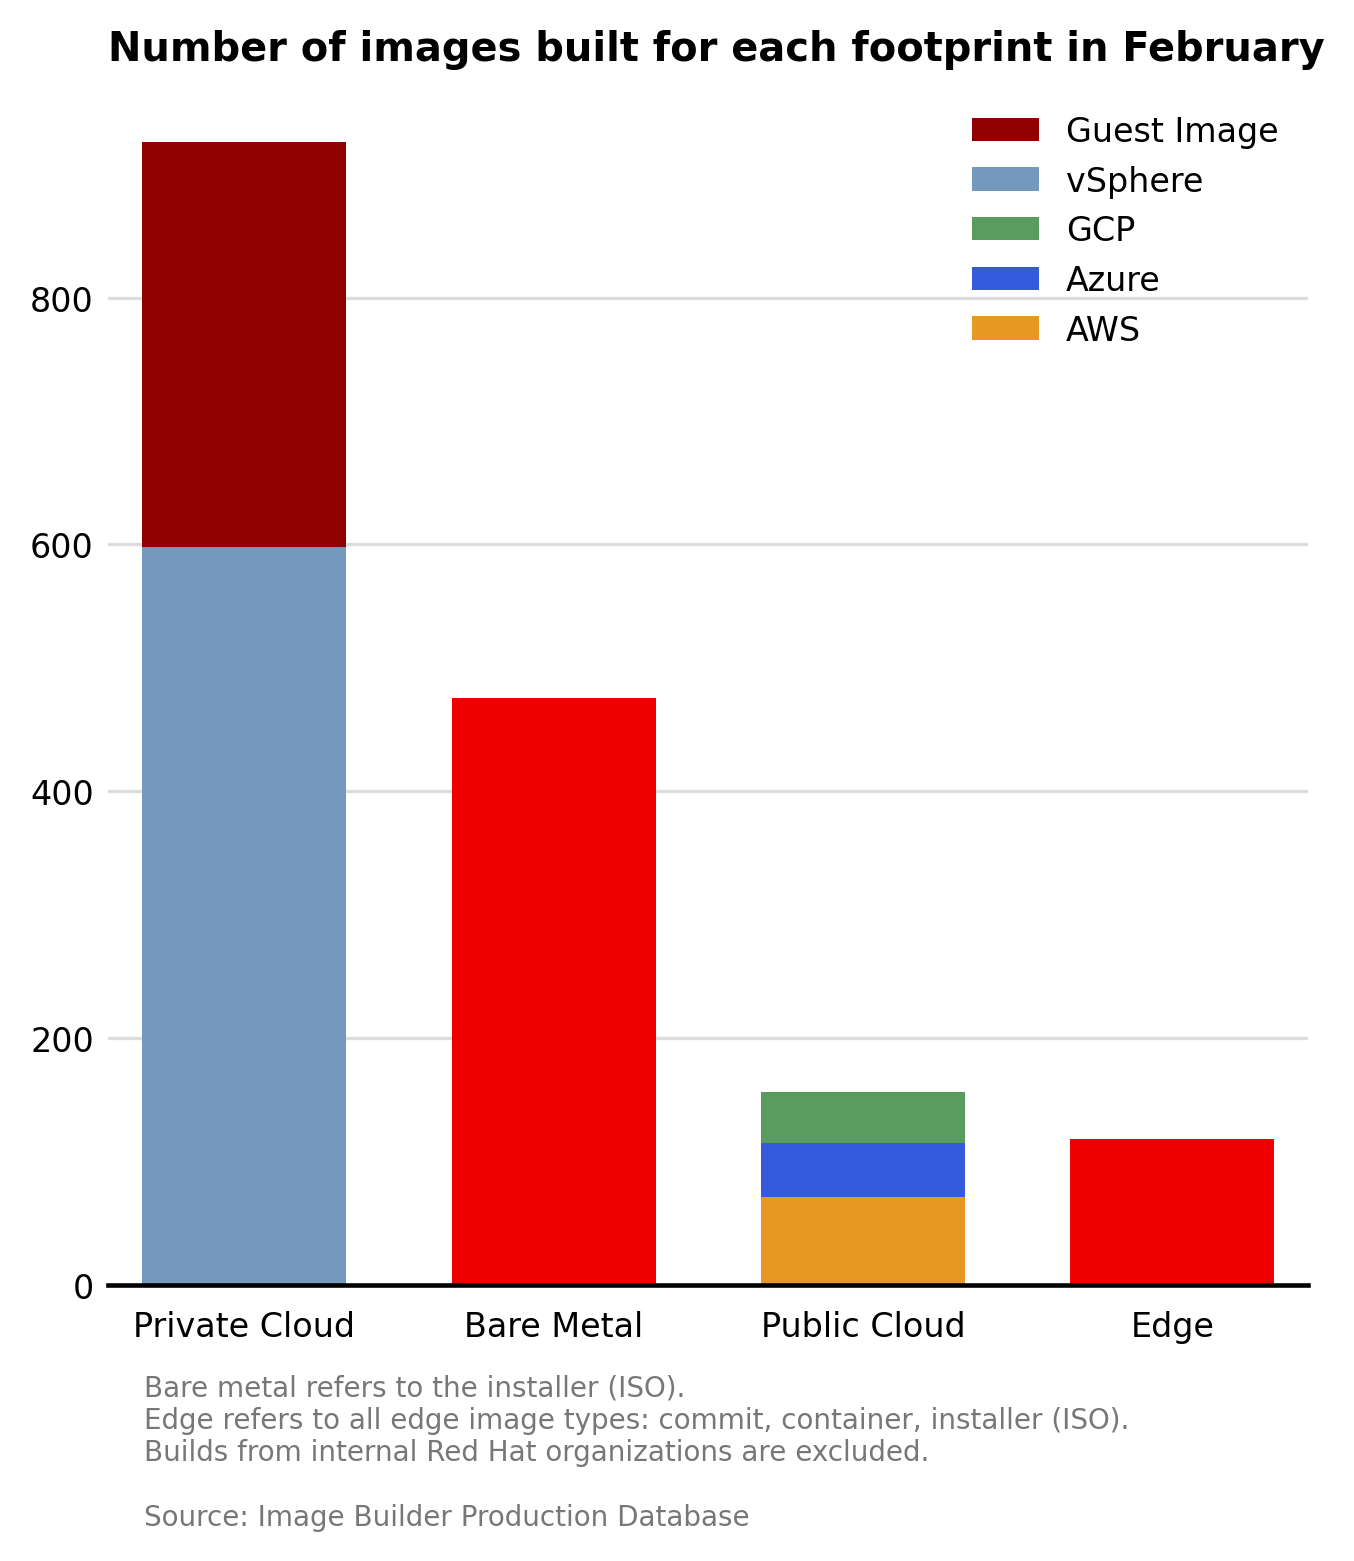

In [10]:
# Number of images for each footprint for the last month
fig = plt.figure(figsize=(4, 4))
prev_month_end = month_start - timedelta(days=1)
prev_month_start = datetime(year=prev_month_end.year, month=prev_month_end.month, day=1)

month_name = prev_month_end.strftime("%B")
month_builds = builds.loc[builds["created_at"] > prev_month_start]
ib.plot.footprints_stacked(month_builds, fig, title=f"Number of images built for each footprint in {month_name}")